<a href="https://colab.research.google.com/github/Haodong12/AIPI-590/blob/main/assignment_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AIPI 590 - XAI | Assignment #08

In this assignment analyzed the model's sensitivity to various prompt components by generating saliency maps for original and perturbed text prompts, observing how different tokens influence predictions. Built visualizations to demonstrate the impact of keywords, punctuation, and emphasis symbols on the model’s interpretation of each prompt.

Haodong He

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers shap --quiet

In [13]:
!pip install torch torchvision --quiet

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

In [3]:
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [6]:
prompts = [
    "Urgent!!! Please read this email.",
    "Calculate the sum: 2 + 2 = ?",
    "Hello, how are you today?",
    "I would like to take this AI course"
]

In [8]:
def generate_perturbations(prompt):
    return [
        prompt.replace("!", ""),  # Remove symbols
        prompt + "!!",  # Add symbols
        prompt + "?",
        prompt + " *important*",
        prompt + " $%^&",
        prompt.replace("Urgent", "like"),  # Replace words
        prompt.replace("2 + 2 = ?", "2 * 2 = ?"),  # Change question type
    ]

# Apply perturbations and display the results
for prompt in prompts:
    perturbed_versions = generate_perturbations(prompt)
    print("Original:", prompt)
    for p in perturbed_versions:
        print("Perturbed:", p)


Original: Urgent!!! Please read this email.
Perturbed: Urgent Please read this email.
Perturbed: Urgent!!! Please read this email.!!
Perturbed: Urgent!!! Please read this email.?
Perturbed: Urgent!!! Please read this email. *important*
Perturbed: Urgent!!! Please read this email. $%^&
Perturbed: like!!! Please read this email.
Perturbed: Urgent!!! Please read this email.
Original: Calculate the sum: 2 + 2 = ?
Perturbed: Calculate the sum: 2 + 2 = ?
Perturbed: Calculate the sum: 2 + 2 = ?!!
Perturbed: Calculate the sum: 2 + 2 = ??
Perturbed: Calculate the sum: 2 + 2 = ? *important*
Perturbed: Calculate the sum: 2 + 2 = ? $%^&
Perturbed: Calculate the sum: 2 + 2 = ?
Perturbed: Calculate the sum: 2 * 2 = ?
Original: Hello, how are you today?
Perturbed: Hello, how are you today?
Perturbed: Hello, how are you today?!!
Perturbed: Hello, how are you today??
Perturbed: Hello, how are you today? *important*
Perturbed: Hello, how are you today? $%^&
Perturbed: Hello, how are you today?
Perturbed

In [36]:
def generate_saliency_map_for_text(model, tokenizer, text, target_class=1):
    # Tokenize the input text and get input IDs as tensors
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    input_ids = inputs["input_ids"]

    # Get the embeddings for the input IDs and enable gradient tracking
    embeddings = model.get_input_embeddings()(input_ids).clone().detach().requires_grad_(True)

    # Forward pass using the embeddings with gradients enabled
    outputs = model(inputs_embeds=embeddings)
    logits = outputs.logits
    probs = F.softmax(logits, dim=1)

    # Get the target probability (e.g., for positive sentiment)
    target_prob = probs[0][target_class]

    # Backward pass to calculate gradients with respect to embeddings
    target_prob.backward()

    # Compute the saliency map as the absolute gradient values for each token
    saliency_map = embeddings.grad.abs().sum(dim=-1).squeeze().detach().cpu().numpy()

    # Map tokens to their saliency scores
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    token_saliency = list(zip(tokens, saliency_map))

    return token_saliency


In [37]:
# Loop through each original prompt and its perturbations, then calculate saliency
for original_prompt in prompts:
    perturbed_prompts = generate_perturbations(original_prompt)
    print(f"Original prompt: '{original_prompt}'\n")

    # Process each perturbed version
    for perturbed_prompt in perturbed_prompts:
        print(f"Perturbed prompt: '{perturbed_prompt}'")

        # Generate saliency map for the perturbed prompt
        saliency_scores = generate_saliency_map_for_text(model, tokenizer, perturbed_prompt)

        # Display saliency scores for each token
        print("Saliency scores:")
        for token, score in saliency_scores:
            print(f"{token}: {score}")
        print("\n")  # Separate results for readability



Original prompt: 'Urgent!!! Please read this email.'

Perturbed prompt: 'Urgent Please read this email.'
Saliency scores:
[CLS]: 61.387794494628906
urgent: 251.95510864257812
please: 174.163330078125
read: 121.92839813232422
this: 66.49954986572266
email: 149.47979736328125
.: 51.962608337402344
[SEP]: 42.54996871948242


Perturbed prompt: 'Urgent!!! Please read this email.!!'
Saliency scores:
[CLS]: 104.94583129882812
urgent: 521.5731811523438
!: 125.48541259765625
!: 93.02166748046875
!: 81.74169921875
please: 195.99957275390625
read: 135.83412170410156
this: 88.33289337158203
email: 195.53567504882812
.: 83.77174377441406
!: 97.12698364257812
!: 97.06578063964844
[SEP]: 53.264862060546875


Perturbed prompt: 'Urgent!!! Please read this email.?'
Saliency scores:
[CLS]: 20.992198944091797
urgent: 113.01616668701172
!: 25.753908157348633
!: 21.845096588134766
!: 18.426654815673828
please: 41.31967544555664
read: 27.137659072875977
this: 16.40394401550293
email: 39.87493133544922
.: 14.

**Observations**

1.Urgent Prompt: "Urgent!!! Please read this email."
Objective: Analyze the model’s sensitivity to urgency-related terms and symbols.

Saliency Summary:

In the original prompt, tokens like "urgent", "please", "email", and punctuation marks . and ! have high saliency scores.
Perturbations such as removing !!!, adding ?, or appending *important* affect the distribution of saliency across tokens.

Keyword Sensitivity: The term "urgent" consistently has the highest saliency score across all perturbations. This indicates that the model strongly focuses on urgency-related words to make predictions, possibly interpreting them as indicative of certain sentiments or intentions (e.g., urgency or importance).

Impact of Symbols:
Adding more ! symbols ('Urgent!!! Please read this email.!!') increased the saliency score for "urgent" significantly (from 251.9 to 521.5). This shows that the model places greater emphasis on urgent or intense expressions.
Replacing "!" with "?" or adding special characters like *important* lowered the saliency scores for "urgent" and other tokens. The saliency for "important" is relatively high, which shows that the model recognizes words related to urgency or importance.

Effect of Removing "Urgent":
When "urgent" was replaced with "like" ('like!!! Please read this email.'), the saliency scores dropped substantially for all tokens, with "like" scoring only 2.5. This suggests that the model relies heavily on words like "urgent" to assign importance to other tokens in the sentence.


2.Instructional Prompt: "Calculate the sum: 2 + 2 = ?"
Objective: Examine the impact of symbols, punctuation, and keywords on an instructional prompt.

Saliency Summary:

In the original prompt, the word "calculate" and the question mark "?" have higher saliency scores, suggesting that the model identifies these as important for interpreting the prompt's intent.
Adding symbols (!!, *important*, $%^&) modifies the distribution of saliency scores, particularly increasing the focus on keywords and punctuation.

Focus on Keywords:
The term "calculate" consistently shows a high saliency score across all perturbations, indicating that the model prioritizes this word when interpreting instructions or questions.

Effect of Emphasis Words:
Adding *important* increased the saliency scores for "calculate", "sum", and "?", highlighting that the model recognizes emphasis cues. The addition of *important* directs more attention to the numerical and instructional parts of the prompt, possibly interpreting them as more significant.
Impact of Symbols and Punctuation:
The addition of punctuation marks (?, !!) increases attention to certain elements, but not as strongly as keywords like "calculate" or phrases like *important*.
When symbols like $%^& were added, the saliency of "calculate" and "sum" remained stable, but the special characters were assigned moderate saliency scores, suggesting that the model treats them as secondary information.
Key Insight:

The model’s interpretation of instructional prompts is influenced mainly by keywords (like "calculate") and numerical operators (like =). While symbols and special characters do impact saliency, their effect is smaller compared to meaningful words or phrases that suggest importance.

3.Neutral Prompt: "Hello, how are you today?"
Objective: Understand how neutral or conversational prompts are affected by symbols and keywords.

Saliency Summary:

The original prompt has balanced saliency scores, with "hello" and "today" slightly more important than other tokens.
Perturbations such as adding !!, ?, or *important* do not significantly alter the model's focus.

Low Sensitivity to Symbols:
Adding exclamation marks (!!) or additional question marks has a minimal effect on the model’s saliency scores. For example, in 'Hello, how are you today?!!', the score for "hello" changed only slightly compared to the original prompt.
This suggests that the model does not interpret conversational prompts as significantly impacted by punctuation or symbols.
Addition of Keywords:
Adding *important* slightly increases saliency scores, particularly for words like "hello" and "today", but this effect is small compared to the instructional or urgent prompts.
Stable Saliency Distribution:
Across all perturbations, saliency scores remain relatively stable, indicating that the model does not react strongly to modifications in conversational prompts. This stability suggests that the model’s attention is distributed more evenly in neutral statements.
Key Insight:

For neutral prompts, the model exhibits low sensitivity to symbols and keyword modifications, suggesting that conversational or non-urgent statements do not heavily rely on specific components to guide interpretation.


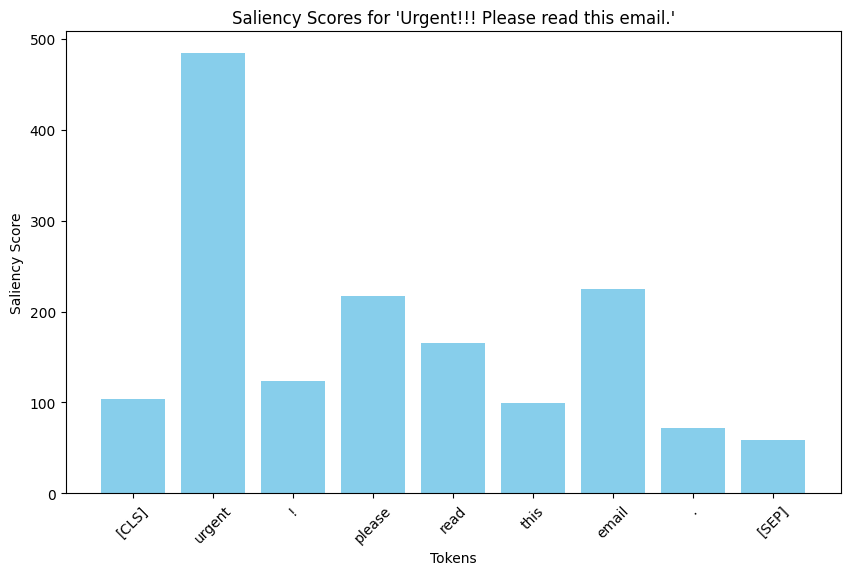

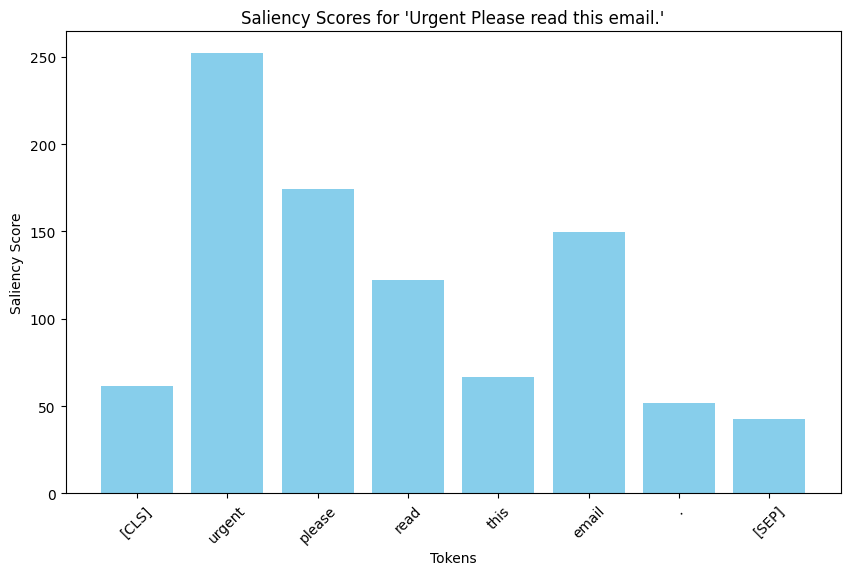

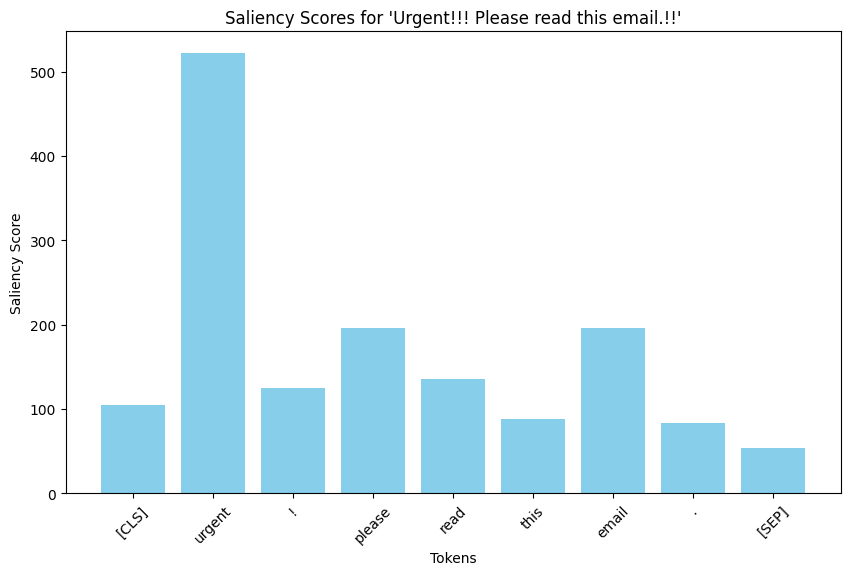

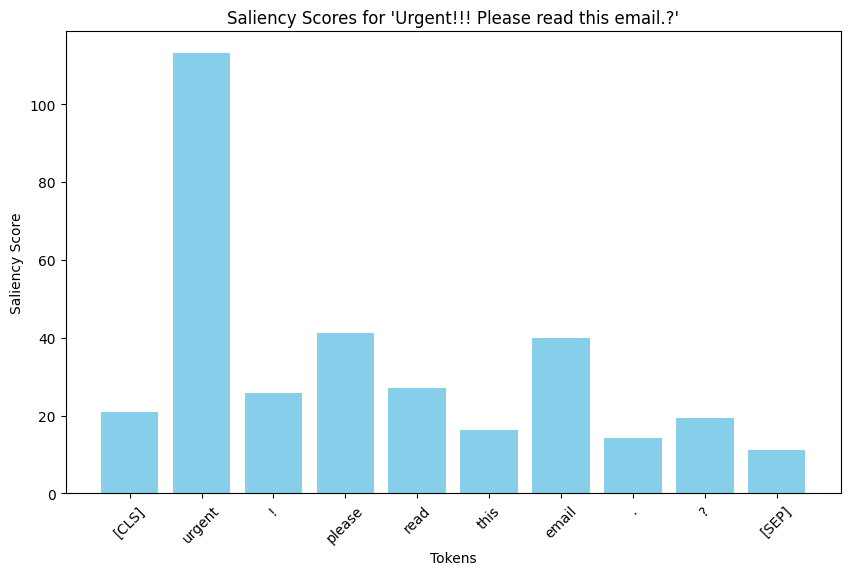

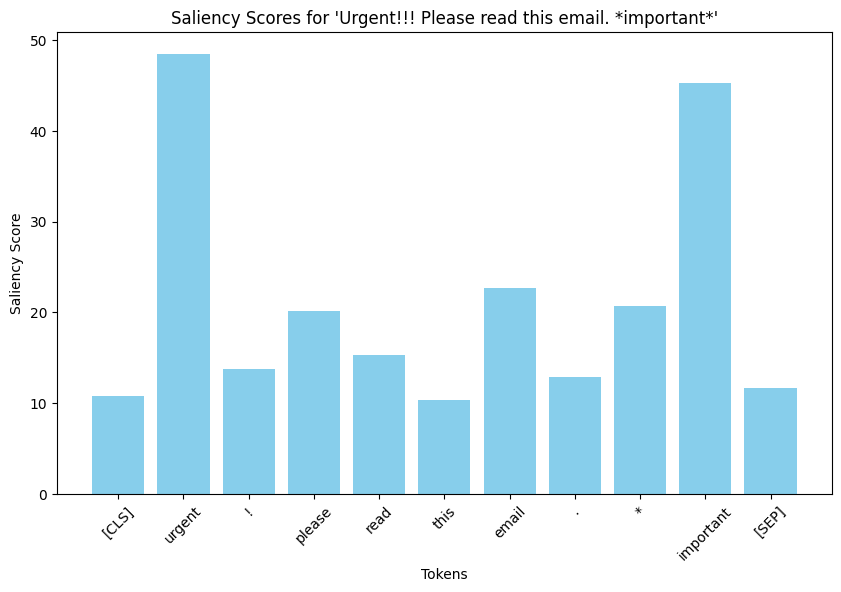

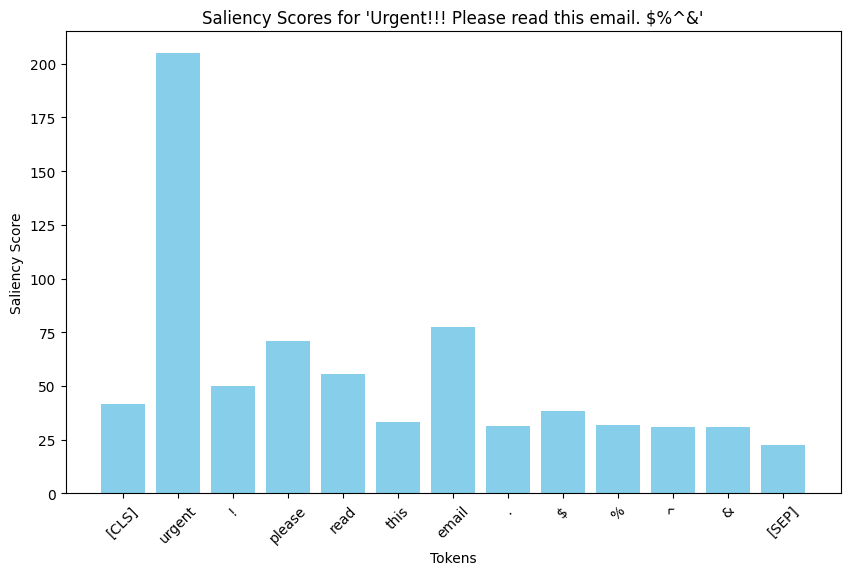

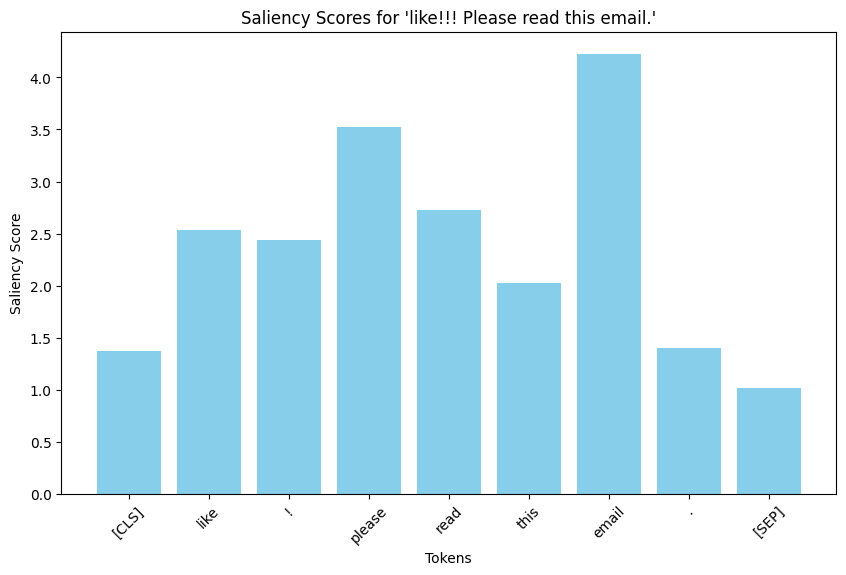

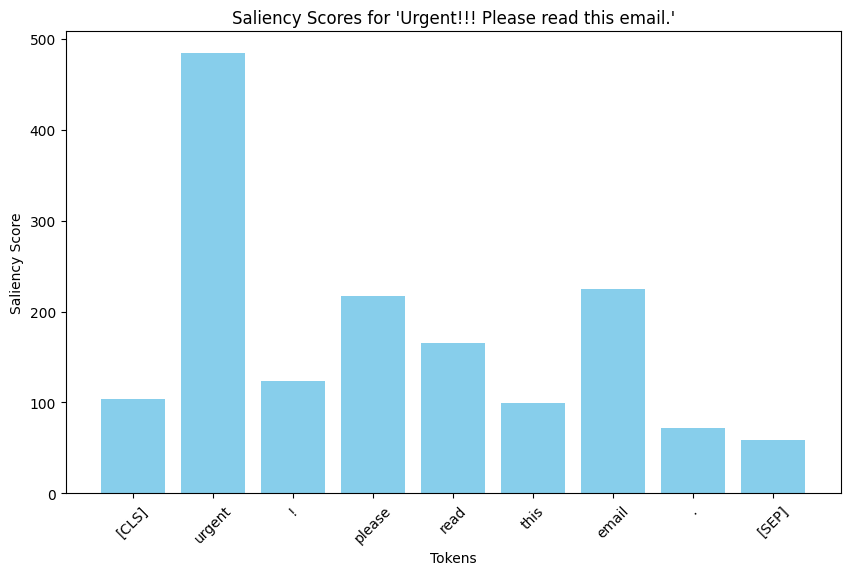

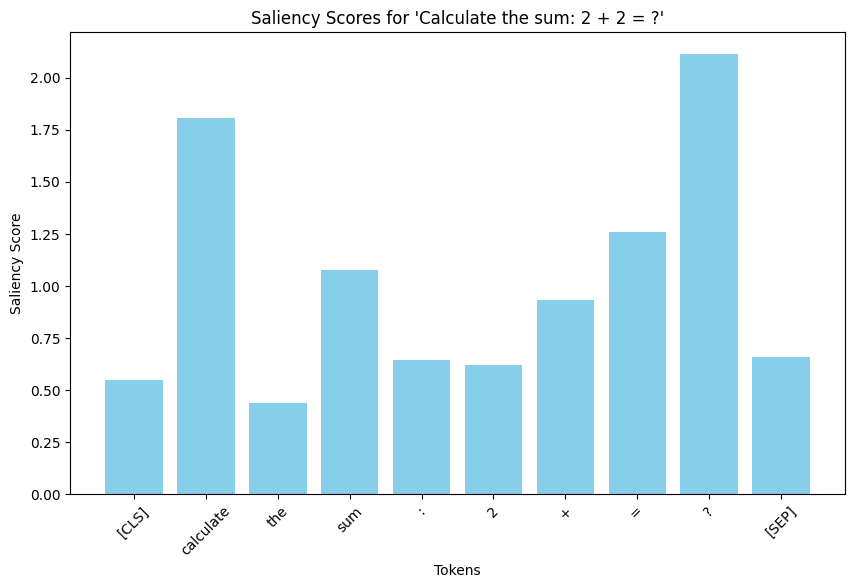

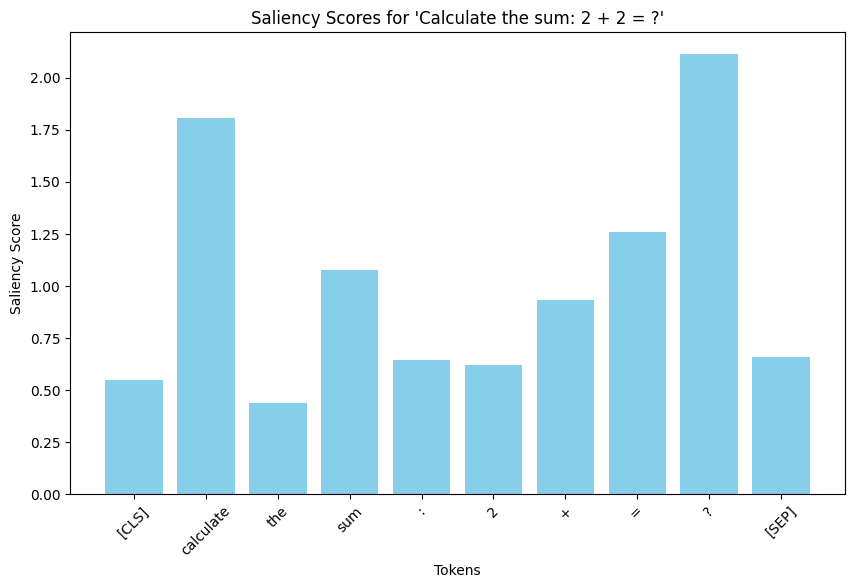

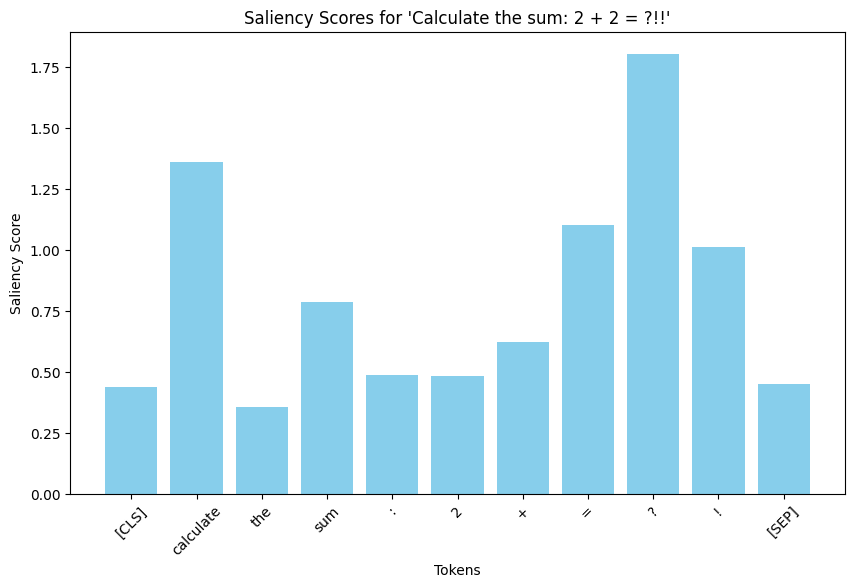

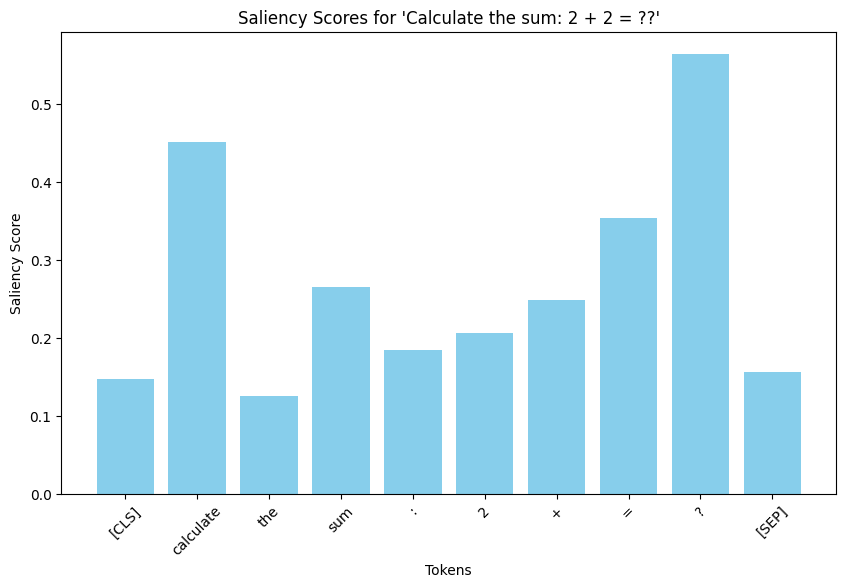

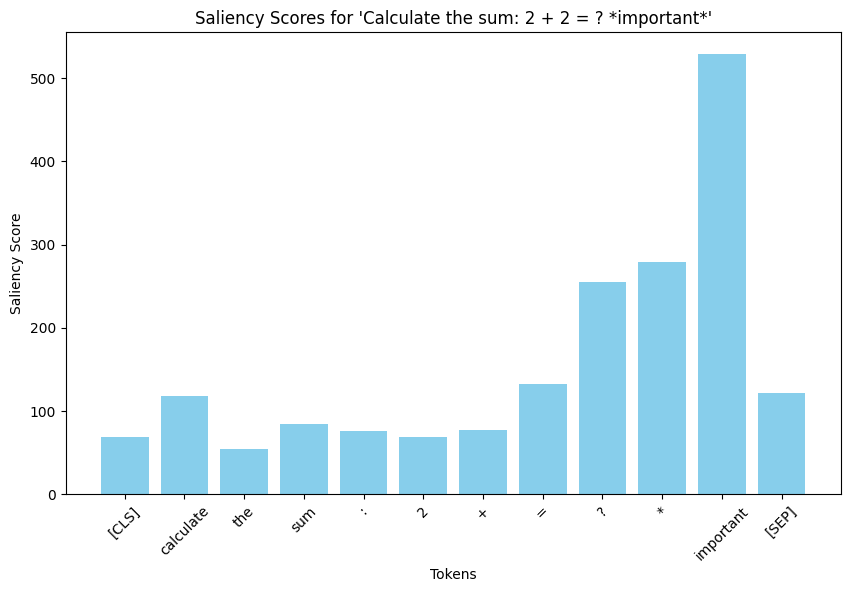

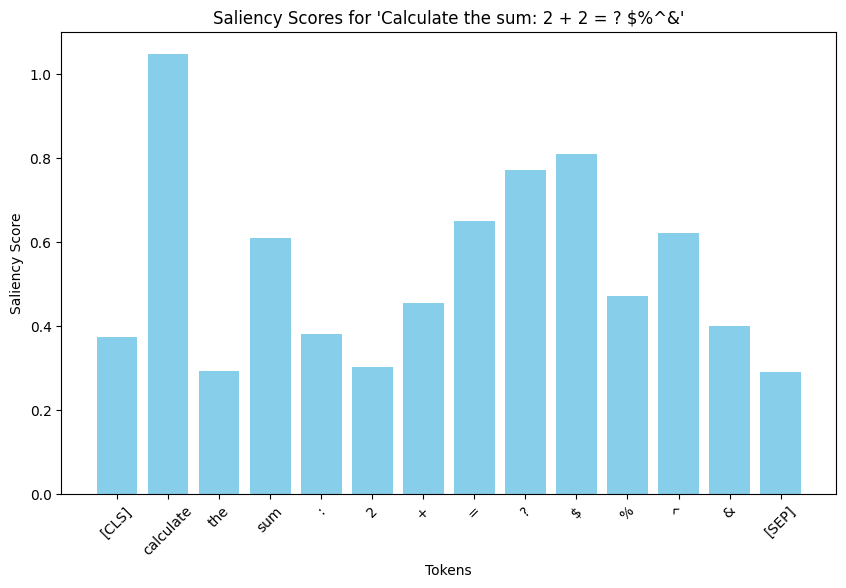

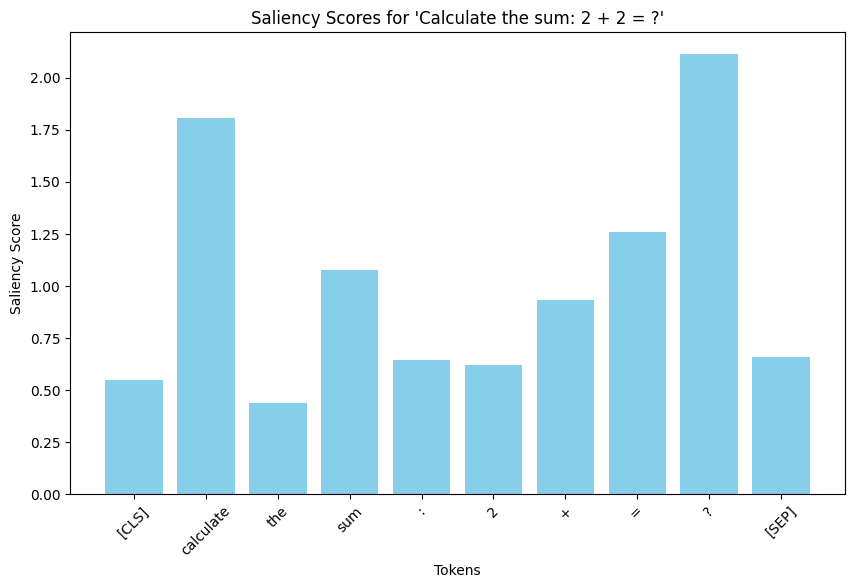

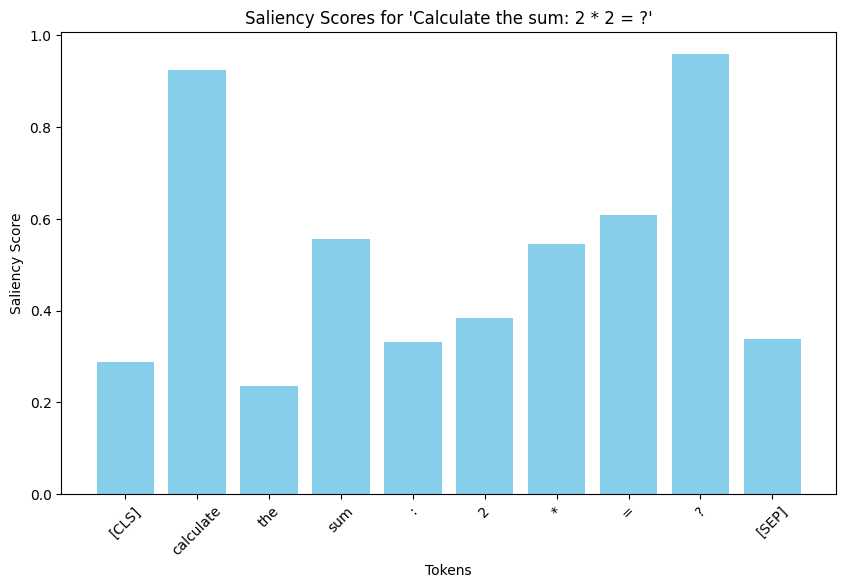

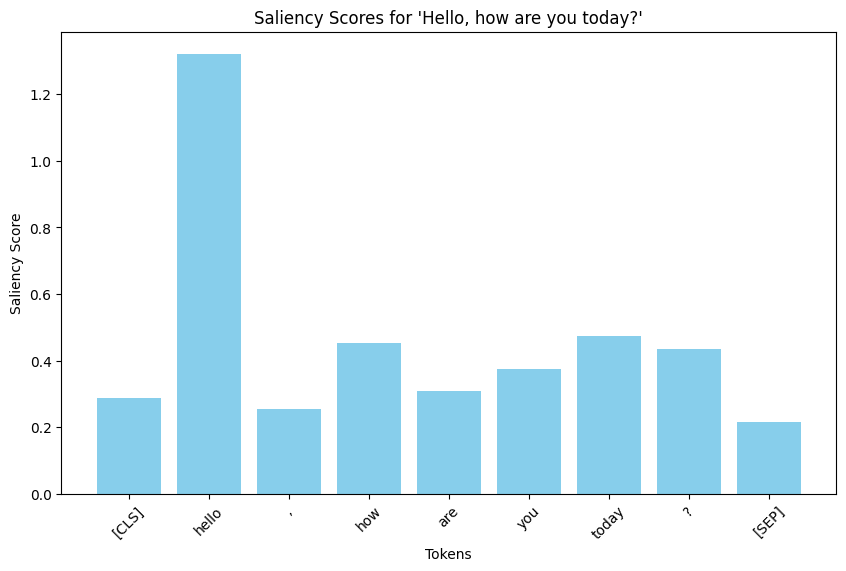

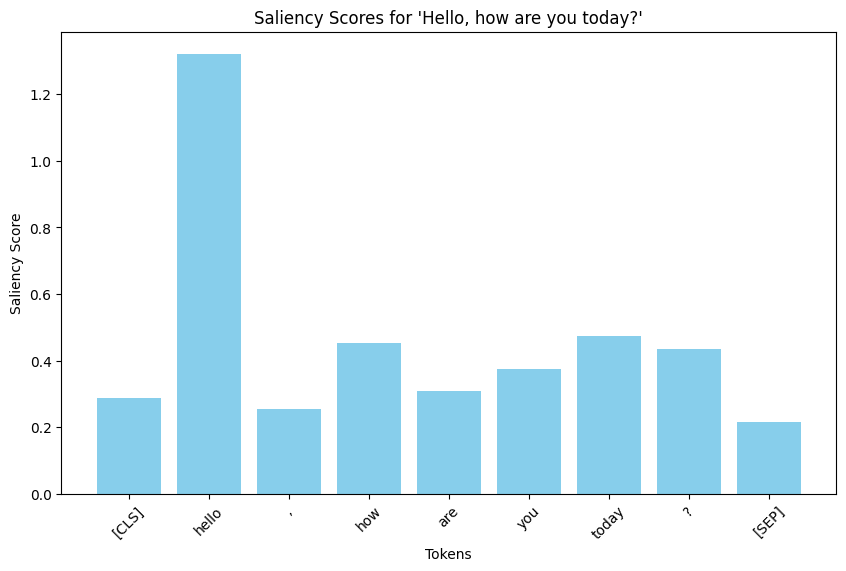

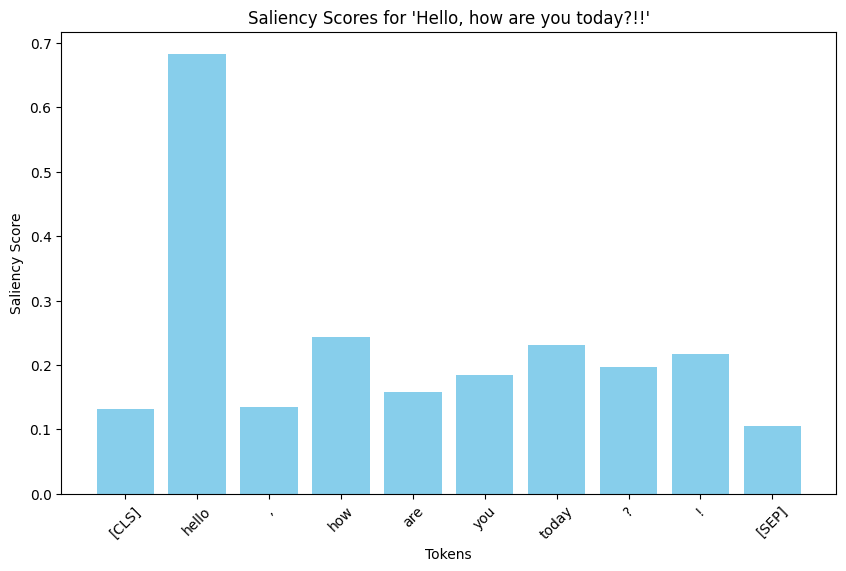

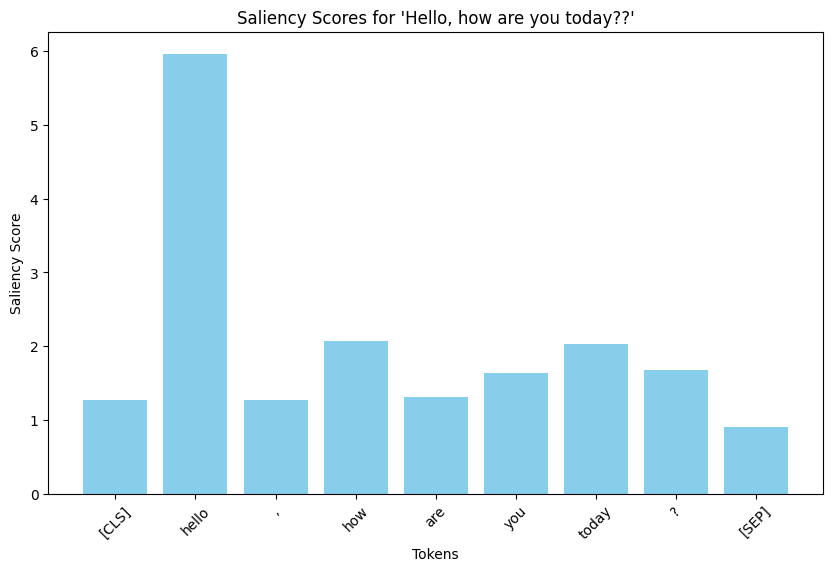

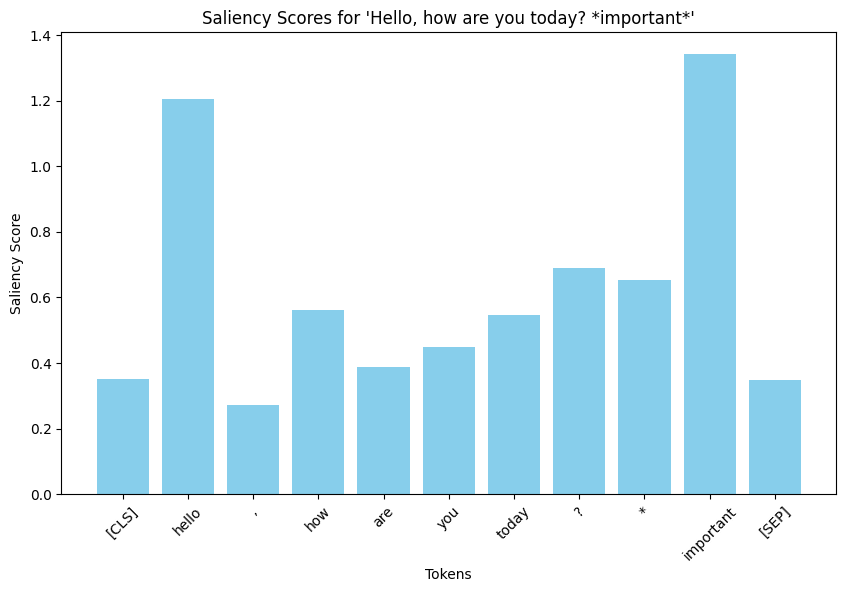

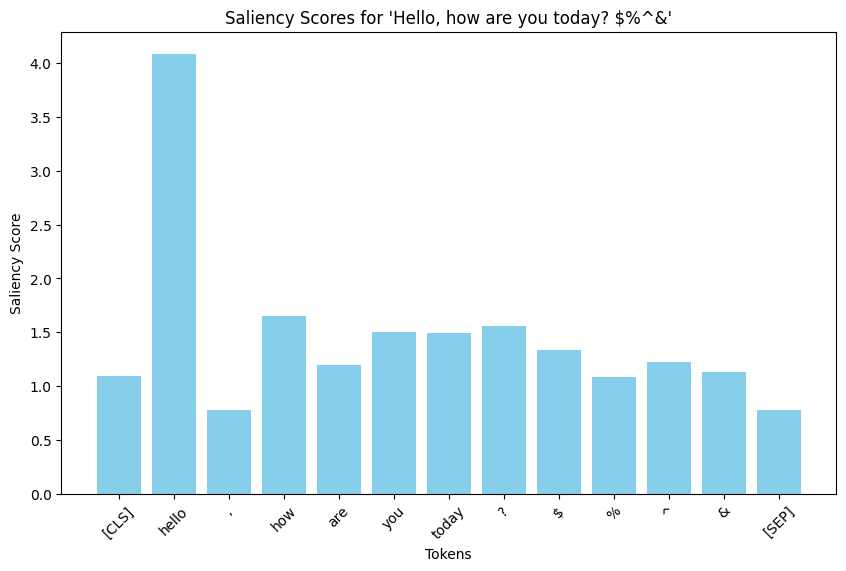

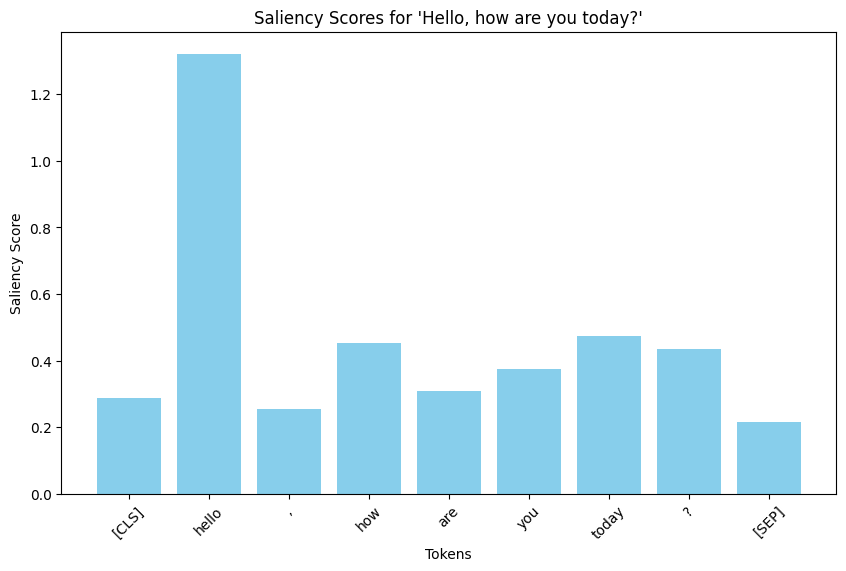

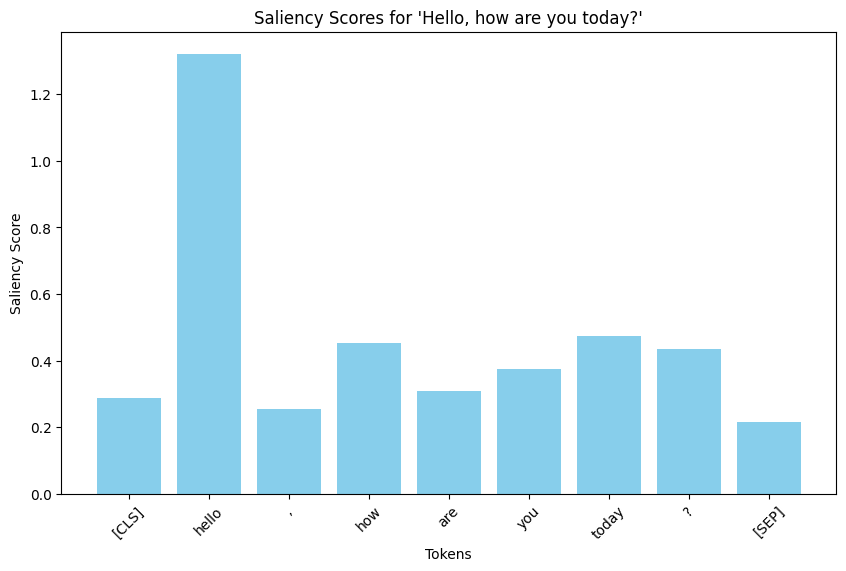

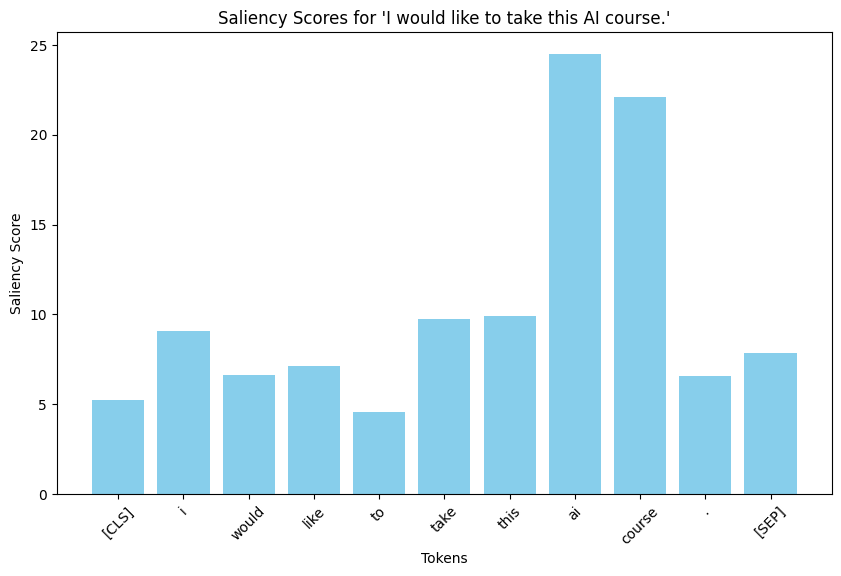

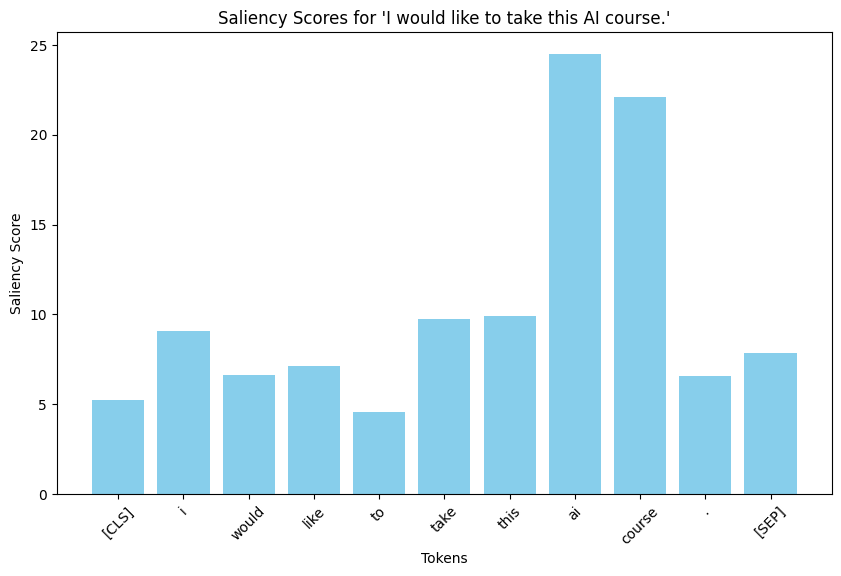

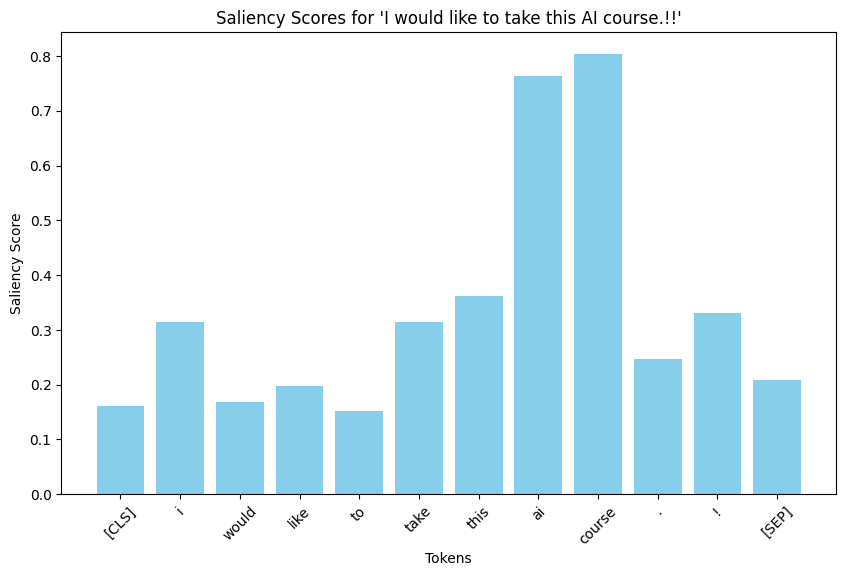

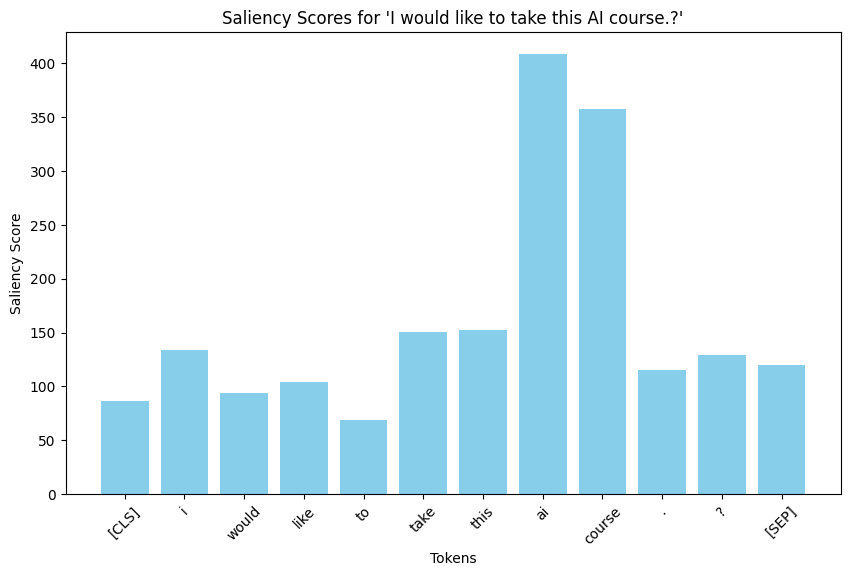

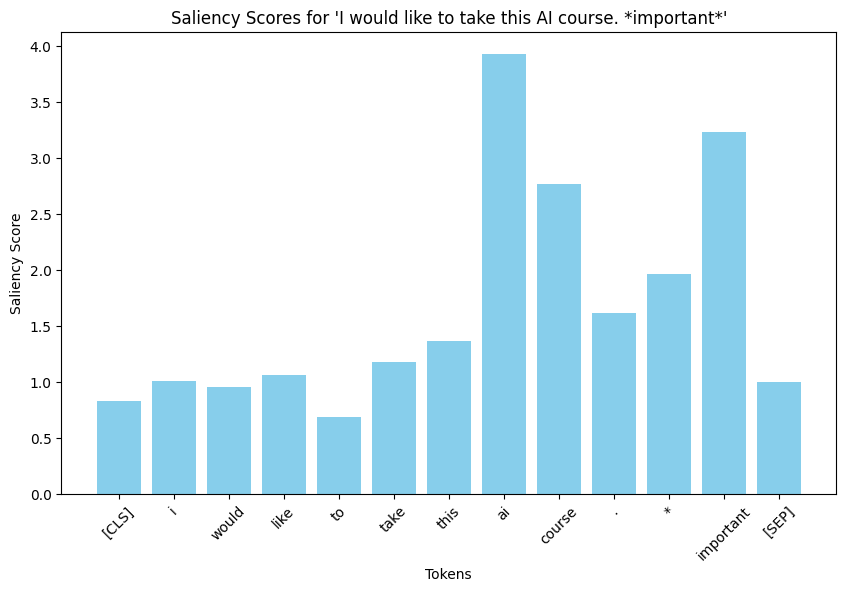

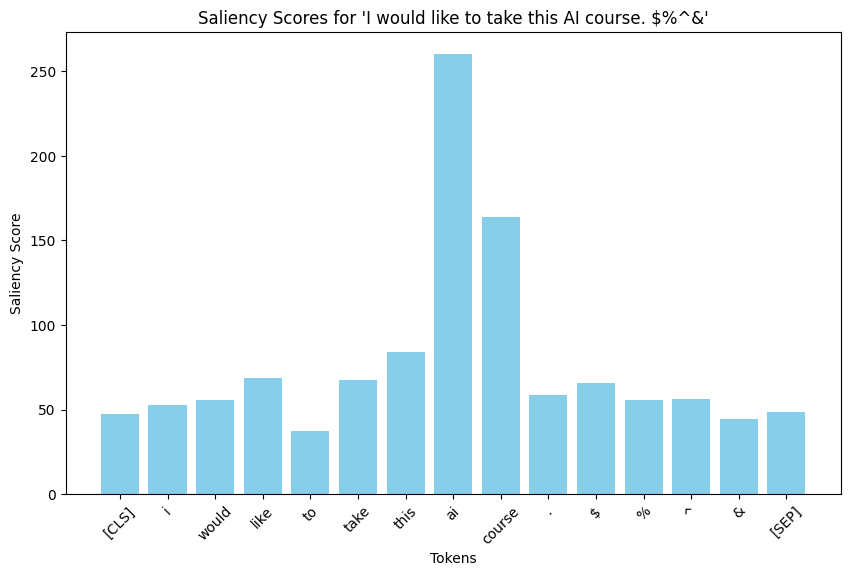

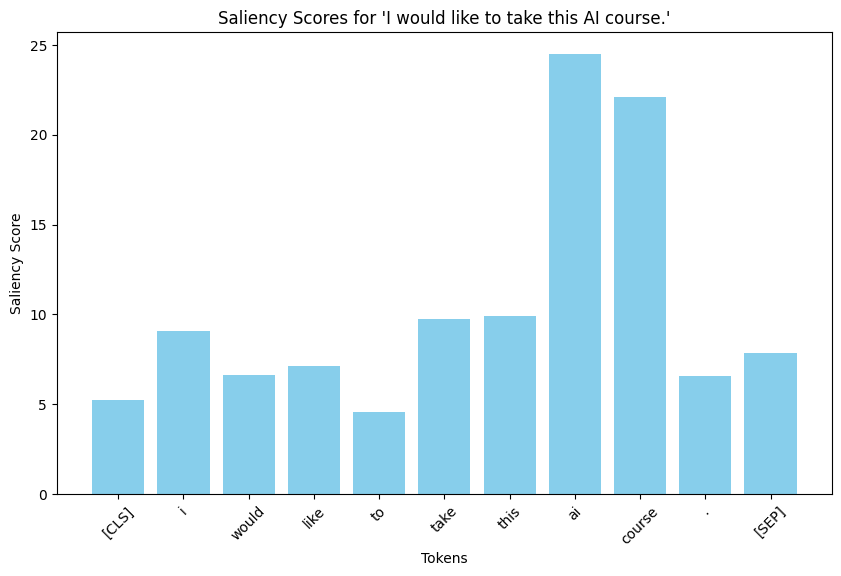

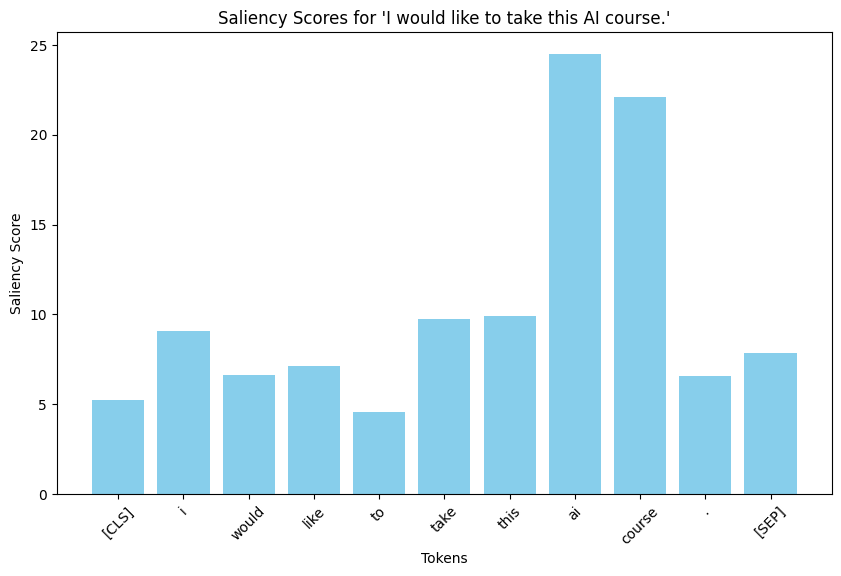

In [44]:
## Barchart for exhibiting the saliency scores
# Define a function to plot the saliency scores
def plot_saliency_bar_chart(tokens, saliency_scores, title):
    plt.figure(figsize=(10, 6))
    plt.bar(tokens, saliency_scores, color='skyblue')
    plt.xlabel("Tokens")
    plt.ylabel("Saliency Score")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# List of prompts
prompts = [
    "Urgent!!! Please read this email.",
    "Calculate the sum: 2 + 2 = ?",
    "Hello, how are you today?",
    "I would like to take this AI course."
]

# Loop over each original prompt and its perturbed versions
for prompt in prompts:
    # Generate perturbations for the current prompt
    perturbed_prompts = generate_perturbations(prompt)

    # Include the original prompt as well
    all_versions = [prompt] + perturbed_prompts

    for version in all_versions:
        saliency_scores = generate_saliency_map_for_text(model, tokenizer, version)

        # Extract tokens and scores
        tokens = [token for token, score in saliency_scores]
        scores = [score for token, score in saliency_scores]

        # Plot the saliency scores
        plot_saliency_bar_chart(tokens, scores, f"Saliency Scores for '{version}'")

